# TP3: Detector de SPAM

**Integrantes:**
- Carreras, Sebastian
- Fajardo, Lucas
- Más Valdecantos, Marcelo A.

---
Uno de los problemas más comunes en la clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo. La detección de SPAM es un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para eludir los filtros de correo no deseado. Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado una variedad de técnicas más avanzadas en la detección de SPAM, que incluyen algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico, utilizaremos un conjunto de datos que consta de 4601 observaciones de correos electrónicos, de los cuales 2788 son correos legítimos y 1813 son correos SPAM. Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo de alguna manera. Para este conjunto de datos, ya se ha aplicado un procesamiento típico en el Procesamiento del Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural (NLP) desempeña un papel fundamental en la detección de SPAM, ya que permite analizar el contenido de los correos electrónicos y extraer características relevantes para la clasificación. Además de contar la frecuencia de palabras, se pueden utilizar técnicas más sofisticadas, como la extracción de características semánticas y el análisis de sentimientos, para mejorar la precisión de los modelos de detección de SPAM.

En este proceso, se cuenta la cantidad de ocurrencias de cada palabra en los diferentes correos.

![spam counter](./spam.png)

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras se encuentra normalizada. El conjunto de datos está compuesto por 54 columnas de atributos que se denominan:

- `word_freq_XXXX`: Donde `XXXX` es la palabra o símbolo. Los valores son enteros que van de 0 a 20k.

Además, hay una columna adicional llamada `spam`, que es 1 si el correo es SPAM o 0 si no lo es.

Los clasificadores de Bayes ingenuos fueron los primeros filtros utilizados por las aplicaciones de correo electrónico, basados en este principio de palabras. La idea es que, partiendo de un dato a priori sobre la probabilidad de que un correo sea SPAM o no, ciertas palabras nos indicarán que la probabilidad a posteriori, dadas esas palabras, es más probable que el correo sea SPAM o no.

---
#### 1.¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM? ¿Hay palabras en común? ¿Algunas llaman la atención?


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn nos ofrece una variedad ampliada de modelos Naive Bayes, para este problema usamos MultinomialNB que es pensado para este tipo de problemas
from sklearn.naive_bayes import MultinomialNB   

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve

In [5]:
dataset = pd.read_csv("dataset/spambase.csv") # cargando los datos desde un CSV
dataset.head(100)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,460,0,0,0,460,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96,0,350,700,0,350,0,0,0,0,0,...,0,0,0,0,122,0,1284,0,0,1
97,0,430,430,0,430,0,0,0,0,0,...,0,0,0,0,147,0,736,0,0,1
98,0,0,0,0,0,600,0,0,0,1210,...,0,0,0,207,518,414,310,0,0,1


In [6]:
# Esto eliminará cualquier espacio en blanco al inicio o al final de los nombres de las columnas.
dataset.columns = dataset.columns.str.strip()

In [10]:
#Obtenemos los palabras mas usadas. 
column_sum = dataset.groupby(by="spam", as_index=False).sum()

In [12]:
#  Filtramos los datos para solo los correos etiquetados como spam
spam_word_counts = column_sum[column_sum['spam'] == 1]

In [14]:
# Eliminamos la columna Spam 
spam_word_counts = spam_word_counts.drop(columns=["spam"])

In [16]:
# Transponemos el DataFrame para que las palabras sean los índices
transposed_spam_word_counts = spam_word_counts.T

# Renombramos la columna resultante, en caso de que no tenga un nombre adecuado
transposed_spam_word_counts.columns = ['numero_de_palabras']

# Ordenamos las palabras por su frecuencia en orden descendente
most_frequent_words = transposed_spam_word_counts.sort_values(by='numero_de_palabras', ascending=False)

# Mostramos las n palabras más frecuentes
n = 10
print(most_frequent_words.head(n))


                    numero_de_palabras
word_freq_you                  4105599
word_freq_your                 2502597
word_freq_will                  997100
word_freq_free                  939790
word_freq_our                   931799
char_freq_!                     931352
word_freq_all                   732080
word_freq_mail                  635470
word_freq_email                 578759
word_freq_business              521250


In [18]:
# Hacemos lo mismo para las mails que no son spam
no_spam_word_counts = column_sum[column_sum['spam'] == 0]

In [20]:
# Eliminamos la columna Spam 
no_spam_word_counts = no_spam_word_counts.drop(columns=["spam"])

In [22]:
# Transponemos el DataFrame para que las palabras sean los índices
transposed_no_spam_word_counts = no_spam_word_counts.T

# Renombramos la columna resultante, en caso de que no tenga un nombre adecuado
transposed_no_spam_word_counts.columns = ['numero_de_palabras']

# Ordenamos las palabras por su frecuencia en orden descendente
no_spam_most_frequent_words = transposed_no_spam_word_counts.sort_values(by='numero_de_palabras', ascending=False)

# Mostramos las n palabras más frecuentes en mails que no son Spam 
n = 10
print(no_spam_most_frequent_words.head(n))

                   numero_de_palabras
word_freq_you                 3541702
word_freq_george              3527559
word_freq_hp                  2496576
word_freq_will                1495268
word_freq_your                1223098
word_freq_hpl                 1204398
word_freq_re                  1159138
word_freq_edu                  800669
word_freq_address              681569
word_freq_meeting              604460


---

#### Respuesta 1
##### ¿Hay palabras en común?
- Podemos Observar que la palabra "you" es la que más se repite en el caso de Spam y No Spam, las otras palabras que más se repiten en ambos casos son "will" y "your".
##### ¿Algunas llaman la atención?
- La palabra que llama la atención, o más bien el signo, por su frecuencia de aparición en el correo de spam, es el signo de admiración “!”.



---
#### 2. Separe el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba (70% y 30% respectivamente).

In [26]:
# Obtenemos los atributos y target
X = (dataset.drop(columns="spam") * 100).astype(int)
#X = dataset2.drop(columns="spam")
y = dataset["spam"]

In [28]:
# Separamos el conjunto de datos como fue indicado.
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3)

---
#### 3. Utilizando un clasificador de Bayes ingenuo, entrene con el conjunto de entrenamiento.

In [31]:
#Escalamos los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformamos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [33]:
X_train_scaled

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.010254,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.0,0.192519,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.029405,0.000000,0.000000
2,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.016304,0.0,0.000000,0.039582,0.000000
4,0.0,0.039216,0.109804,0.0,0.123212,0.162791,0.309491,0.000000,0.0,0.030803,...,0.026144,0.0,0.0,0.0,0.000000,0.008511,0.0,0.015487,0.000000,0.004186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,0.0,0.000000,0.115686,0.0,0.000000,0.000000,0.000000,0.053105,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.040094,0.0,0.000000,0.000000,0.000000
3216,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3217,0.0,0.004902,0.027451,0.0,0.015402,0.020349,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.019156,0.018150,0.0,0.000000,0.000000,0.000000
3218,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.009360,0.000000,0.000000


In [35]:
#Entrenamos el modelo de bayes ingenuo multinomial
naives_bayes_spam = MultinomialNB()
naives_bayes_spam.fit(X_train_scaled, y_train)

MultinomialNB()

---
#### 4. Utilizando un clasificador de Regresión Logística, entrene con el conjunto de entrenamiento (en este caso, normalice los datos).

In [38]:
classifier_balance_spam = LogisticRegression(random_state = 0, class_weight="balanced")

In [40]:
classifier_balance_spam.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

---
#### 5. Calcule la matriz de confusión del conjunto de evaluación para ambos modelos. ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?

In [43]:
# Hacer predicciones con ambos modelos
y_pred_logistic = classifier_balance_spam.predict(X_test_scaled)
y_pred_naive_bayes = naives_bayes_spam.predict(X_test_scaled)

In [45]:
# Calcular las matrices de confusión de LR
y_pred_logistic_binary = np.where(y_pred_logistic > 0.5, 1, 0)

In [47]:
# Calcular las matrices de confusión de NB
confusion_logistic = confusion_matrix(y_test, y_pred_logistic_binary)  # Ensure y_test is defined

In [49]:
print("Matriz de Confusión - Regresión Logística:")
print(confusion_logistic)

Matriz de Confusión - Regresión Logística:
[[755  78]
 [ 62 486]]


In [51]:
# Calcular las matrices de confusión de LR
y_pred_naive_bayes_binary = np.where(y_pred_naive_bayes > 0.5, 1, 0)

In [53]:
confusion_naive_bayes = confusion_matrix(y_test, y_pred_naive_bayes_binary)  

In [55]:
print("Matriz de Confusión - Regresión Logística:")
print(confusion_naive_bayes)

Matriz de Confusión - Regresión Logística:
[[801  32]
 [127 421]]


---

#### Respuesta 5
##### ¿Qué tipo de error comete más cada modelo? 
- Cuando entrenamos el modelo con LR la matriz de Confusión nos da la siguiente información:
    -   "Verdaderos Negativos",746 mails detectados de que un mail no es Spam correctamente.
    -   "Verdaderos positivos",477 mails detectados de que un mail es Spam correctamente.
    -   "Falsos Positivos", 91 mails que no son spam se los detecto como spam.
    -   "Falsos Negativos", 67 mails que son spam se los detecto como no spam.
- Cuando entrenamos el modelo con BI  la matriz de Confusión nos da la siguiente información:
    -   "Verdaderos Negativos", 786 mails detectados de que un mail no es Spam correctamente.
    -   "Verdaderos positivos", 428 mails detectados de que un mail es Spam correctamente.
    -   "Falsos Positivos", 51 mails que no son spam se los detecto como spam.
    -   "Falsos Negativos", 116 mails que son spam se los detecto como no spam.
##### ¿Cuál de los dos tipos de error crees que es más importante para este problema?
- Para este problema lo mas grave  es que se detecte como spam a un mail que no es spam, podemos concluir que el modelo de Bayes ingenuo fue el mejor, porque se "equivoco" menos al seleccionar mails que no son spam como spam.

---
#### 6. Calcule la precisión y la recuperación de ambos modelos. Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.

In [71]:
# Accuracy Regresión Logística:
accuracy_logistic = classifier_balance_spam.score(X_test, y_test)
print(f"Porcentaje de muestras bien clasificadas (Regresión Logística): {accuracy_logistic * 100:.2f}%")

# Accuracy Bayes Ingenuo:
accuracy_naives = naives_bayes_spam.score(X_test, y_test)
print(f"Porcentaje de muestras bien clasificadas (Bayes Ingenuo): {accuracy_naives * 100:.2f}%")

Porcentaje de muestras bien clasificadas (Regresión Logística): 79.87%
Porcentaje de muestras bien clasificadas (Bayes Ingenuo): 87.98%


---

#### Respuesta 6
##### ¿Cuál es el mejor modelo?
- Podemos observar que el modelo con mejor precision es el de Bayes ingenuo que tiene un 87.76% de muestras bien clasificadas vs el 80.74 de la regresión logística

##### ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior?
- La precisión se calcula como:
                
precisión =  $ \frac{VerdaderosNegativos + VerdaderosPositivos}{VerdaderosNegativos + VerdaderosPositivos + FalsosNegativos + FalsosPositivos} $
             
- Es decir, la precisión refleja la proporción de predicciones correctas (tanto positivas como negativas) sobre el total de predicciones.
- Aunque la precisión es útil para evaluar el rendimiento global, puede ser engañoso en datasets desbalanceados.
- La precisión da una visión global del rendimiento del modelo, pero la matriz de confusión permite un análisis más fino de los tipos de errores cometidos.
- A nosotros nos interesa saber el dato de los falsos positivos, más que otro dato, por lo que nos conviene siempre calcular la matriz de confusión.


---
#### 7. Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.

In [121]:
y_prob_rl = classifier_balance_spam.predict_proba(X_test_scaled)[:, -1] # Regresión Logística
y_prob_naive =  naives_bayes_spam.predict_proba(X_test_scaled)[:, -1] # Naive Bayes

# Calculamos la curva ROC y el AUC para ambos modelos
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_rl)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_naive)

roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_nb = auc(fpr_nb, tpr_nb)

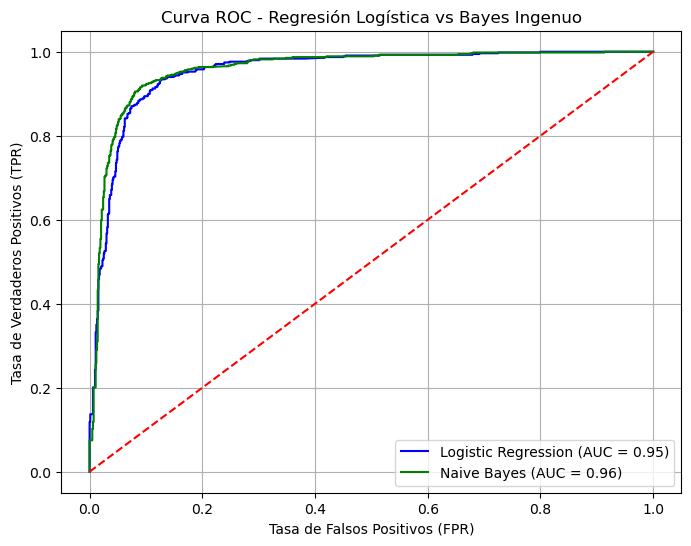

In [123]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_nb, tpr_nb, color='green', label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística vs Bayes Ingenuo')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()